In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import stats
import cv2
import sys

def compute_receptive_field(act, x, y, bin_size):
    # batch size and the number of neurons
    num_neuron = act.shape[0];
    # sampling size for gaussian smoothing
    sample_size = int(np.minimum(bin_size[0], bin_size[1]) / 4);
    if sample_size % 2 == 0 :
        sample_size += 1;
    
    # receptive field
    receptive_fields = np.zeros((num_neuron, bin_size[1], bin_size[0]));
    # compute receptive field with spatial position
    map_x = x.reshape(-1);
    map_y = y.reshape(-1);
    for neuron_idx in np.arange(num_neuron):
        f = act[neuron_idx, :].reshape(-1);
        ratemap, _, _, _ = stats.binned_statistic_2d(map_y, map_x, f, 
                                                     statistic = lambda x : np.mean(x),
                                                     bins = [bin_size[1], bin_size[0]]);
        # Nan value complete
        ratemap_nan = np.copy(ratemap);
        nan_idx = np.where(np.isnan(ratemap_nan));
        
        # gaussian sampling 
        ratemap_nan[nan_idx] = 0.0;
        ratemap_nan = cv2.GaussianBlur(ratemap_nan, (sample_size, sample_size), 0);
        ratemap[nan_idx] = ratemap_nan[nan_idx];
        receptive_fields[neuron_idx] = ratemap;
    return receptive_fields;

def plot_receptive_field(activity, traj, plot_size=[1,1], bin_length=50, fig_size=[10,10]):
    ratemaps = compute_receptive_field(activity, traj[:, 0], traj[:, 1], [int(traj[:, 0].size/bin_length), int(traj[:, 1].size/bin_length)]);
    num_neuron = ratemaps.shape[0];
    plt.figure(figsize=fig_size);
    #plt.axis('off');
    for neuron_idx in range(plot_size[0]*plot_size[1]):
        plt.subplot(plot_size[0], plot_size[1], neuron_idx + 1);
        plt.imshow(np.flipud(ratemaps[neuron_idx]), interpolation = 'gaussian');
    plt.show();

def simulate_plot(funcs, env_range, n, plot=True, bin_length=50, fig_size=[15,15]):
    traj_x = np.random.rand(n) * (env_range[0][1]-env_range[0][0]) + np.ones((n)) * env_range[0][0]
    traj_y = np.random.rand(n) * (env_range[1][1]-env_range[1][0]) + np.ones((n)) * env_range[1][0]
    traj = np.array([traj_x, traj_y]).T
    
    activity = np.array([[func(pos) for pos in traj] for func in funcs])
    if plot:
        plot_receptive_field(activity, traj, plot_size=[int(len(funcs)**0.5), int(len(funcs)**0.5)], bin_length=bin_length, fig_size=fig_size)
    return traj, activity

def plot_traj(traj, env_range=[(-200, 200), (-200, 200)]):
    #print((np.min(traj[:, 0]), np.max(traj[:, 0])));
    #print((np.max(traj[:, 1]), np.min(traj[:, 1])));
    plt.figure();
    plt.subplot(1, 1, 1);
    plt.plot(traj[:, 0], traj[:, 1], 'ko-');
    plt.xlim(env_range[0]);
    plt.ylim(env_range[1]);
    #plt.xlim((np.min(traj[:, 0]), np.max(traj[:, 0])));
    #plt.ylim((np.min(traj[:, 1]), np.max(traj[:, 1])));
    #plt.axis('scaled');
    #plt.axis('off');
    plt.title('Trajectory');
    plt.show();

In [57]:
### Grid Cell Sheet ###
sin60 = np.sqrt(3)/2.0

class GCSheet:
    def __init__(self, N):
        self.Nx = int(round(np.sqrt(N/sin60)))
        self.Ny = int(round(self.Nx * sin60))
        self.N = self.Nx * self.Ny
        #print(self.Nx, self.Ny)
        
        self.poses = [[i+1, j+1] for i in range(self.Nx) for j in range(self.Ny)] #poses[n-1] = [int(n/self.Ny)+1, n%self.Ny]
        self.alpha = np.random.uniform(0.01, 0.03) # smaller -> larger spacing # [1,3]
        self.beta = np.random.uniform(0, np.pi/3)
        self.R = np.array([[np.cos(self.beta), -np.sin(self.beta)], [np.sin(self.beta), np.cos(self.beta)]])
        
        self.A = np.random.uniform(0, 1/np.sqrt(self.N), self.N) # initial activity
        self.updateW([0, 0]) # initial weights
        
    def distTri(self, i, j, v): # i, j are [x,y], where 1<=x<=Nx, 1<=y<=Ny
        ci = np.array([(i[0]-0.5)/self.Nx, (i[1]-0.5)/self.Ny*sin60])
        cj = np.array([(j[0]-0.5)/self.Nx, (j[1]-0.5)/self.Ny*sin60])
        s = np.array([[0,0],[-0.5,sin60],[-0.5,-sin60],[0.5,sin60],[0.5,-sin60],[-1,0],[1,0]])
        return np.min(np.linalg.norm(np.tile(ci, (7,1)) - np.tile(cj, (7,1)) + np.tile(v, (7,1)) + s, axis=1))
        
    def dynamic(self):
        tau = 0.8
        B = np.matmul(self.w, self.A.T)
        self.A = np.clip((1-tau)*B + tau*B/np.sum(self.A), 0, None)
        
    def updateW(self, v): # v: [vx, vy]
        I = 0.3
        T = 0.05
        sigma = 0.24 # unit: meter # 0.24
        
        v = self.alpha * np.matmul(self.R, np.array(v).T)
        self.w = np.array([[I * np.exp(-(self.distTri(i,j,v)**2)/sigma**2) - T for i in self.poses] for j in self.poses])
        self.w *= np.ones(self.w.shape) - np.identity(self.N) # eliminate self-recurrent?

class GCpop:
    def __init__(self, N, Nsheets):
        self.Nneurons = N*Nsheets
        self.sheets = []
        for i in range(Nsheets):
            self.sheets.append(GCSheet(N))
            for t in range(300):
                self.sheets[-1].dynamic()
        self.data = np.zeros((0, self.Nneurons))
                
    def updateW(self, v):
        for s in self.sheets:
            s.updateW(v)
    def dynamic(self, record=False):
        for s in self.sheets:
            s.dynamic()
        if record:
            self.data = np.append(self.data, np.array([s.A for s in self.sheets])).reshape((-1, self.Nneurons))

0 100 200 300 400 500 600 700 800 900 

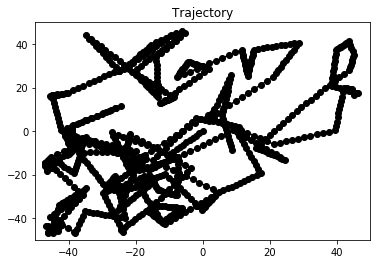

In [58]:
### quick test environment ###

gc = GCpop(30, 10)
pos = [0,0]
traj = [pos]
gc.dynamic(True)

for i in range(1000):
    if i%100 == 0:
        sys.stdout.write(str(i)+" ")
    if i%10 == 0 or pos[0]<-45 or pos[0]>45 or pos[1]<-45 or pos[1]>45:
        v = np.random.uniform(-2, 2, 2)
        t = pos + v
        while t[0]<-50 or t[0]>50 or t[1]<-50 or t[1]>50:
            v = np.random.uniform(-2, 2, 2)
            t = pos + v
        gc.updateW(v)
    
    pos = pos + v
    traj.append(pos)
    gc.dynamic(True)

plot_traj(np.array(traj), env_range=[(-50, 50), (-50, 50)])


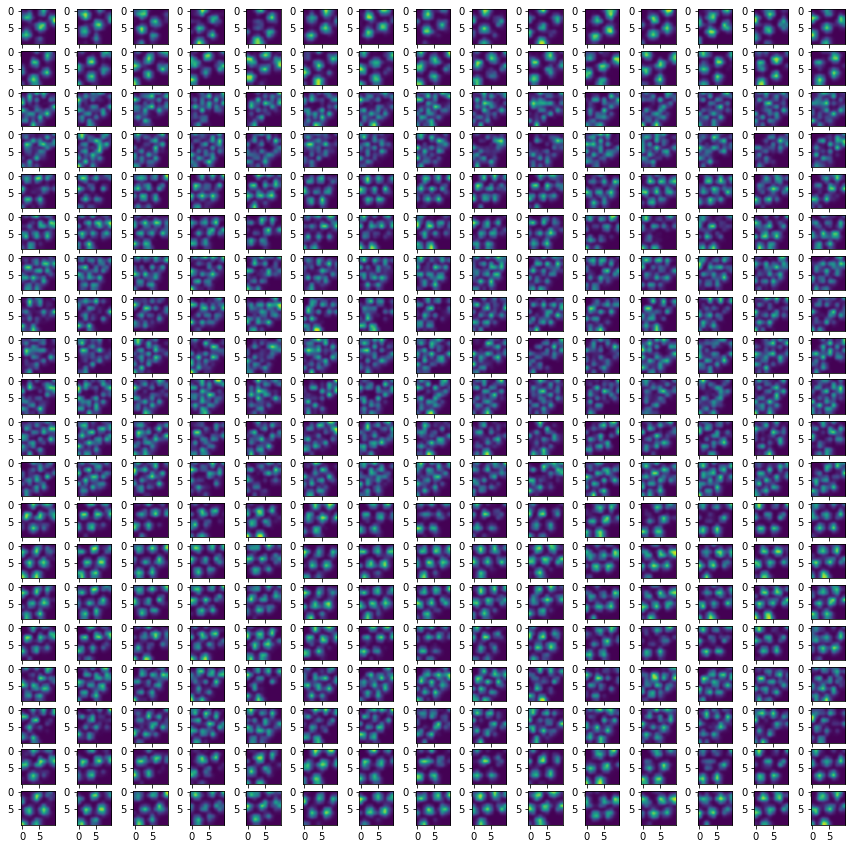

In [59]:
plot_receptive_field(gc.data.T, np.array(traj), plot_size=[20,15], bin_length=100, fig_size=[15,15])

In [48]:
### visual/motion place cells (with competitive learning) ###

class PlaceCell: 
    def __init__(this, nDim, eta=0.2, mapSize=[10, 10], inFilter=0.0, noise=0.003): 
        this.inFilter = inFilter # for MPC
        this.noise = noise
        this.eta = eta;
        #this.mapSize = mapSize; # 2D size of number of place fields
        this.nDim = nDim; # number of pixels of visual input; number of motion grid cells
        this.nNodes = mapSize[0] * mapSize[1];
        this.n_x = mapSize[0];
        this.n_y = mapSize[1];
        
        # create weight space
        this.w = np.random.rand(this.nDim, this.nNodes);
        # normalize the weight
        this.w = this.w / np.tile(np.sqrt(np.sum(this.w * this.w, axis = 0)), (this.nDim, 1));
        
        # recurrent weights (Hopfield; fire-together-wire-together)
        this.rw = np.zeros((this.nNodes, this.nNodes))

    def train(this, dataSet, nIter=1):
        cnt = 0;
        nSamples = dataSet.shape[0];
        sys.stdout.write('Training In VPC/MPC Competitve Learning: ');
        for iterIdx in range(nIter):
            for sampleIdx in range(nSamples):
                # get one sample
                sample = dataSet[sampleIdx : sampleIdx + 1];
                winIdx, neuronOutput = this.computeWinNeuron(sample);
                if this.inFilter>0:
                    this.updateWeight(np.clip(sample-np.amax(sample)*this.inFilter*np.ones(sample.shape), 0, None), winIdx, neuronOutput);
                else:
                    this.updateWeight(sample, winIdx, neuronOutput);
                
                cnt = cnt + 1;
                if cnt % 1000 == 0:
                    sys.stdout.write(str(cnt) + ' ');
        sys.stdout.write('\n');
    
                
    def computeWinNeuron(this, neuronInput):
        # forward output
        neuronOutput = np.dot(neuronInput, this.w)
        # add some noise
        winIdx = np.argmax(neuronOutput + np.amax(neuronOutput) * this.noise * this.nNodes * np.random.rand(1, this.nNodes));
        
        return winIdx, neuronOutput;

    
    def updateWeight(this, neuronInput, winIdx, neuronOutput):
        dw = this.eta * neuronInput * neuronOutput[0, winIdx];
        # on-line update the winning neuron weight
        this.w[:, winIdx : winIdx + 1] += dw.T;
        # normalization
        if np.sum(this.w[:, winIdx]) != 0:
            this.w[:, winIdx] = this.w[:, winIdx] / np.sqrt(np.sum(this.w[:, winIdx] * this.w[:, winIdx]));
        
    def estimate(this, x, e=0.925):
        # forward output
        y = np.dot(x, this.w);
        # E% max inhibition
        y = y - e * np.tile(np.reshape(np.max(y, 1), [-1, 1]), [1, y.shape[1]]);
        y = y * (y > 0);
        y = y / (1.0 - e);
        return y;
    
    def trainHopfield(this, y):
        tmp = np.zeros((y.shape[0], this.nNodes, this.nNodes))
        for i in range(y.shape[0]):
            tmp[i] = np.matmul(y[i].reshape((1, -1)).T, y[i].reshape((1, -1)))
        this.rw = np.sum(tmp, axis=0)
        mask = np.ones((this.nNodes, this.nNodes)) - np.identity(this.nNodes)
        this.rw = this.rw*mask
        plt.figure();
        plt.imshow(this.rw.reshape(this.nNodes, this.nNodes));
        plt.show();
        print(np.argmax(this.rw), np.argmax(this.rw)/this.rw.shape[0], np.argmax(this.rw)%this.rw.shape[0])

Training In VPC/MPC Competitve Learning: 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 


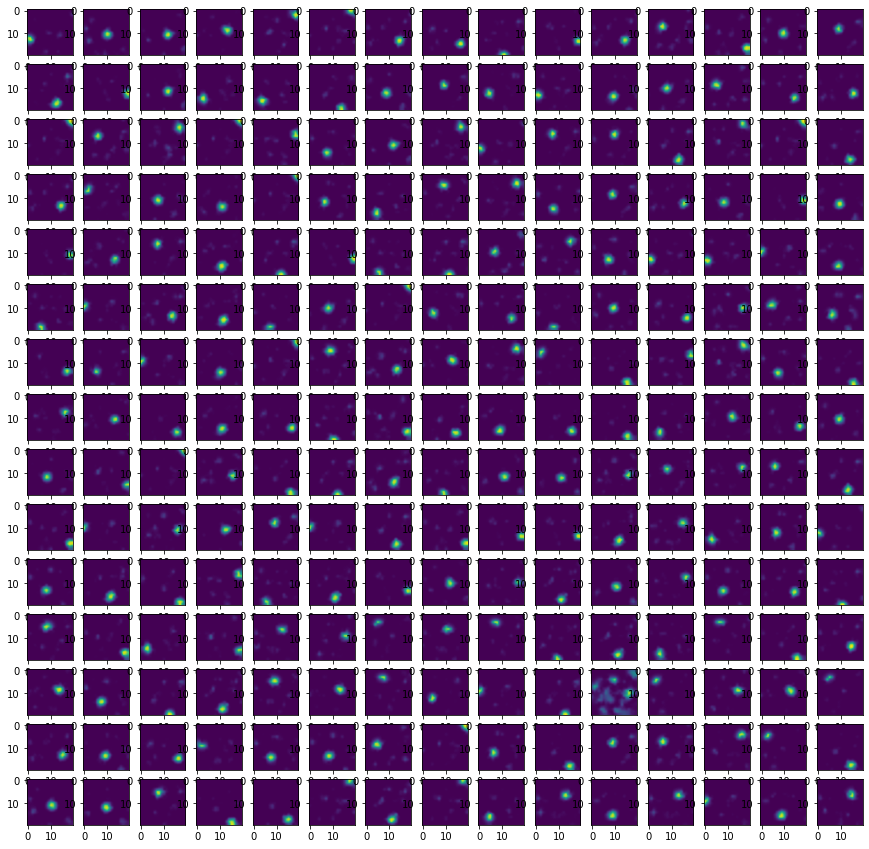

In [53]:
pc = PlaceCell(gc.Nneurons, eta=0.8, inFilter=0.2, mapSize=[15,15])
pc.train(gc.data, nIter=50)

# show the weight matrix
#plt.figure(figsize = [15, 15]);
#for pcIdx in np.arange(100):
#    plt.subplot(10, 10, pcIdx + 1);
#    plt.imshow(pc.w[:, pcIdx].reshape(3, 30));
#plt.show();


# estimation
pred_y = pc.estimate(gc.data, e=0.45)
plot_receptive_field(pred_y.T, np.array(traj), plot_size=[15,15], bin_length=100, fig_size=[15,15])

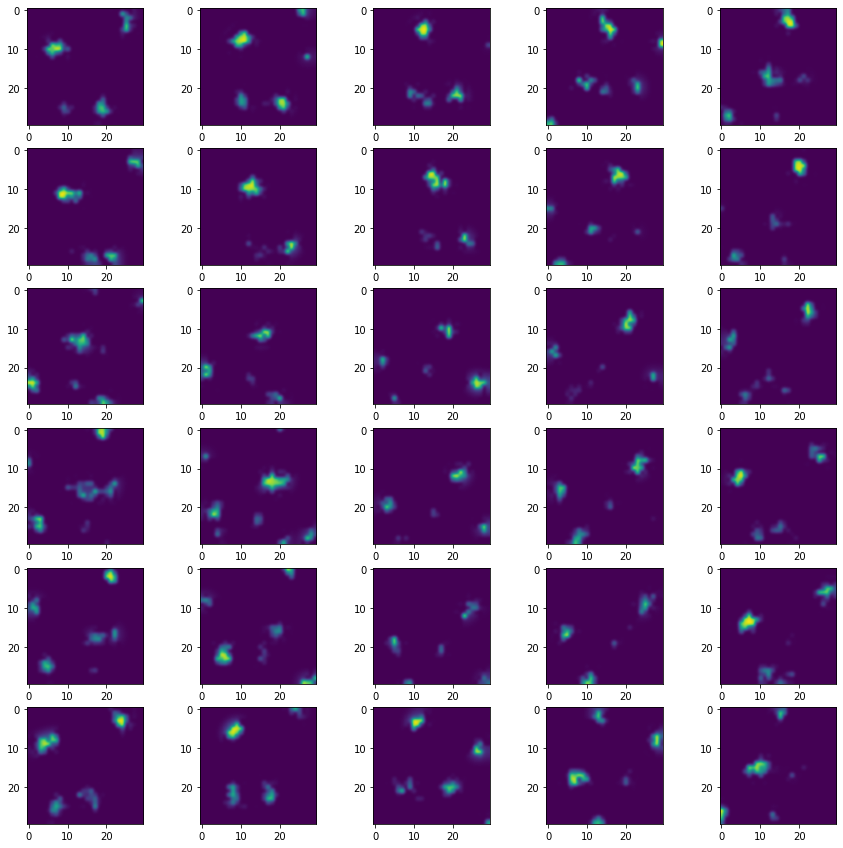

In [109]:
### NOT USED ###
### place cells by summing grid cells at the same position in different sheets ###
Nx = gc.sheets[0].Nx
Ny = gc.sheets[0].Ny
N = gc.sheets[0].N

y = []

for i in range(N):
    pcA = np.zeros((gc.data.shape[0]))
    for l in range(len(gc.sheets)):
        pcA += gc.data[:, l*N+i].reshape((-1))
    y.append(pcA)

e=0.98
y=np.array(y).T

y = y - e * np.tile(np.reshape(np.max(y, 1), [-1, 1]), [1, y.shape[1]]);
y = y * (y > 0);
y = y / (1.0 - e);
plot_receptive_field(y.T, np.array(traj), plot_size=[Nx,Ny], bin_length=100, fig_size=[15,15])